## V tem koraku bi rad preveril katera kombinacija fingerprinta in klasifikacijskega modela je najboljša preden začnem manipulirati s podatki. Ta korak je pomemben zato da v nadaljnih korakih vidim kaj izboljšujem

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC  # Import SVC for Support Vector Machine
from sklearn.metrics import accuracy_score
import numpy as np
import logging
import optuna

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Load data
try:
    df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_extended.csv')
    y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
    X = df.iloc[:, 3:]  # Assuming features start from the 4th column
except Exception as e:
    logger.error(f"Error loading data: {e}")
    exit()

# Remove constant features
selector = VarianceThreshold()
X = pd.DataFrame(selector.fit_transform(X), columns=selector.get_feature_names_out())

# Split the data into interim and test sets
X_interim, X_test, y_interim, y_test = train_test_split(
    X, y, test_size=0.10, random_state=kon.random_seed, shuffle=True, stratify=y
)

# Split the interim data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_interim, y_interim, test_size=10/90, random_state=kon.random_seed, shuffle=True, stratify=y_interim
)

# Define the objective function for Optuna
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)  # Regularization parameter
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Kernel type
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Kernel coefficient

    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        random_state=kon.random_seed
    )

    # Train the model on the training set
    svm.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Log the validation accuracy
    logger.info(f"Trial {trial.number}: Validation Accuracy = {val_accuracy:.4f}")
    
    return val_accuracy

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters from Optuna
best_params = study.best_params
logger.info(f"Best parameters from Optuna: {best_params}")

# Train the final model with the best parameters
final_svm = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],
    random_state=kon.random_seed
)

final_svm.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred = final_svm.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
logger.info(f"Final Validation Accuracy: {val_accuracy:.4f}")

[I 2024-12-21 18:24:33,196] A new study created in memory with name: no-name-41554c76-eb61-457f-b6cb-38a6bd3cebf0
2024-12-21 18:24:34,763 - INFO - Trial 0: Validation Accuracy = 0.8602
[I 2024-12-21 18:24:34,764] Trial 0 finished with value: 0.8602409638554217 and parameters: {'C': 0.019575551289517573, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8602409638554217.
2024-12-21 18:24:35,675 - INFO - Trial 1: Validation Accuracy = 0.8795
[I 2024-12-21 18:24:35,676] Trial 1 finished with value: 0.8795180722891566 and parameters: {'C': 14.513228221168292, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 1 with value: 0.8795180722891566.
2024-12-21 18:24:36,724 - INFO - Trial 2: Validation Accuracy = 0.8819
[I 2024-12-21 18:24:36,725] Trial 2 finished with value: 0.8819277108433735 and parameters: {'C': 16.92249180784123, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: 0.8819277108433735.
2024-12-21 18:24:37,625 - INFO - Trial 3: Validation Accuracy = 

In [3]:
# If you want to visualize feature importances, you can use the coefficients for linear kernel
if best_params['kernel'] == 'linear':
    feature_importances = final_svm.coef_[0]  # Get the coefficients
    features = X.columns

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))  # Top 10 features
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()  # Show the plot

In [4]:
optuna.visualization.plot_optimization_history(study)
plt.show()

In [5]:
from itertools import product
import numpy as np
import pandas as pd
from sklearn.svm import SVC  # Import SVC for Support Vector Machine
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Define the best parameters from Optuna (assuming these are defined)
# best_params = {
#     'C': 1.0,
#     'kernel': 'rbf',
#     'gamma': 'scale'
# }

# Define a grid search based on the best parameters found
param_grid = {
    'C': [
        max(1e-3, best_params['C'] * 0.9),  # Lower bound: 90% of the value
        best_params['C'],
        best_params['C'] * 1.1  # Upper bound: 110% of the value
    ],
    'kernel': [best_params['kernel']],  # Keeping the best kernel
    'gamma': [
        best_params['gamma'],  # Keeping the best gamma
        'scale',  # Adding 'scale' as an option
        'auto'   # Adding 'auto' as an option
    ]
}

# Create a list of all combinations of parameters for grid search
param_combinations = list(product(
    param_grid['C'],
    param_grid['kernel'],
    param_grid['gamma'],
))

# Function to evaluate a single set of parameters
def evaluate_model(params):
    C, kernel, gamma = params
    
    svm = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        random_state=kon.random_seed
    )
    
    try:
        # Perform cross-validation
        cv_scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
        cv_accuracy = np.mean(cv_scores)
        
        # Fit the model on the full training set
        svm.fit(X_train, y_train)
        
        # Evaluate on the validation set
        y_val_pred = svm.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        return {
            "Parameters": {
                "C": C,
                "kernel": kernel,
                "gamma": gamma,
            },
            "CV Accuracy": cv_accuracy,
            "Validation Accuracy": val_accuracy
        }
    except Exception as e:
        logger.error(f"Error with parameters {params}: {e}")
        return None

# Sequentially evaluate the models using grid search
results = []
for params in param_combinations:
    result = evaluate_model(params)
    if result is not None:  # Only append valid results
        results.append(result)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the results DataFrame by Validation Accuracy in descending order
sorted_results_df = results_df.sort_values(by='Validation Accuracy', ascending=False)

# Log the best result
if not sorted_results_df.empty:
    best_result = sorted_results_df.iloc[0]  # Get the first row after sorting
    logger.info(f"Best Parameters: {best_result['Parameters']}, CV Accuracy: {best_result['CV Accuracy']}, Validation Accuracy: {best_result['Validation Accuracy']}")
else:
    logger.warning("No valid results were found during the grid search.")

2024-12-21 18:27:43,349 - INFO - Best Parameters: {'C': 0.4495331370707324, 'kernel': 'poly', 'gamma': 'scale'}, CV Accuracy: 0.8737953001326024, Validation Accuracy: 0.9012048192771084


In [6]:
sorted_results_df

,Parameters,CV Accuracy,Validation Accuracy
3,"{'C': 0.4495331370707324, 'kernel': 'poly', 'g...",0.873795,0.901205
4,"{'C': 0.4495331370707324, 'kernel': 'poly', 'g...",0.873795,0.901205
6,"{'C': 0.4944864507778057, 'kernel': 'poly', 'g...",0.874399,0.901205
7,"{'C': 0.4944864507778057, 'kernel': 'poly', 'g...",0.874399,0.901205
0,"{'C': 0.40457982336365916, 'kernel': 'poly', '...",0.873492,0.898795
1,"{'C': 0.40457982336365916, 'kernel': 'poly', '...",0.873492,0.898795
8,"{'C': 0.4944864507778057, 'kernel': 'poly', 'g...",0.720720,0.754217
5,"{'C': 0.4495331370707324, 'kernel': 'poly', 'g...",0.717398,0.744578
2,"{'C': 0.40457982336365916, 'kernel': 'poly', '...",0.713471,0.730120


In [7]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix

# Assuming the best parameters are already identified
best_params = sorted_results_df.iloc[0]['Parameters']

# Fit the best model on the full training set
best_svc = SVC(
    C=best_params['C'],
    kernel=best_params['kernel'],
    gamma=best_params['gamma'],
    probability=True,  # Enable probability estimates
    random_state=kon.random_seed
)

# Fit the model
best_svc.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = best_svc.predict(X_train)
y_train_prob = best_svc.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class
auc_train_score = roc_auc_score(y_train, y_train_prob)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)

# Make predictions on the validation set
y_val_pred = best_svc.predict(X_val)
y_val_prob = best_svc.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class
auc_score = roc_auc_score(y_val, y_val_prob)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Make predictions on the test set
y_test_pred = best_svc.predict(X_test)
y_test_prob = best_svc.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
auc_test_score = roc_auc_score(y_test, y_test_prob)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Print the results
print(f"AUC Train Score: {auc_train_score:.4f}")
print(f"AUC Validation Score: {auc_score:.4f}")
print(f"AUC Test Score: {auc_test_score:.4f}")
print("Confusion Matrix (Train):")
print(conf_matrix_train)
print("Confusion Matrix (Validation):")
print(conf_matrix_val)
print("Confusion Matrix (Test):")
print(conf_matrix_test)

AUC Train Score: 0.9782
AUC Validation Score: 0.9314
AUC Test Score: 0.9283
Confusion Matrix (Train):
[[1489  142]
 [ 134 1547]]
Confusion Matrix (Validation):
[[181  23]
 [ 18 193]]
Confusion Matrix (Test):
[[176  28]
 [ 22 189]]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Plotting the confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Plotting the ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Training Accuracy: 0.9166666666666666
Training F1 Score: 0.9181008902077151
Training Precision: 0.9159265837773831
Training Recall: 0.9202855443188578


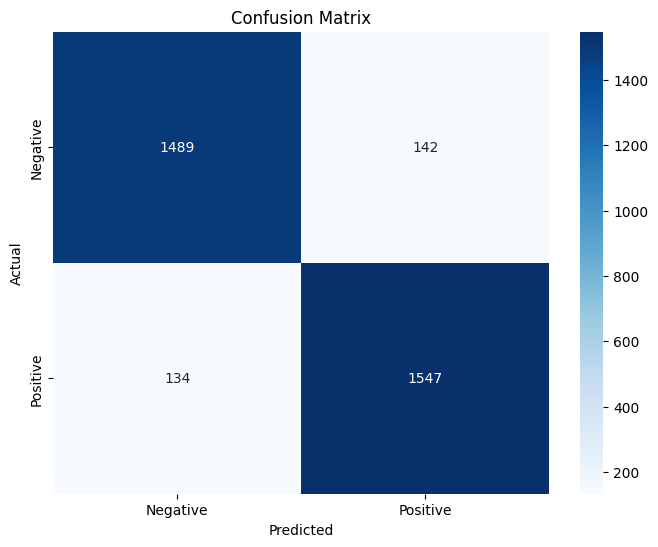

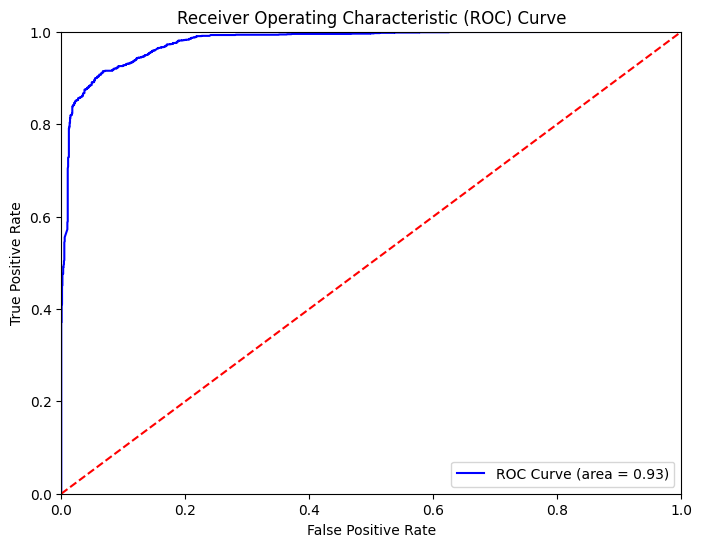

In [9]:
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)

print("Training Accuracy:", accuracy_train)
print("Training F1 Score:", f1_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
# Plotting the confusion matrix for training data
plot_confusion_matrix(conf_matrix_train)
plot_roc_curve(y_train, y_train_prob)

Validation Accuracy: 0.9012048192771084
Validation F1 Score: 0.9039812646370023
Validation Precision: 0.8935185185185185
Validation Recall: 0.9146919431279621


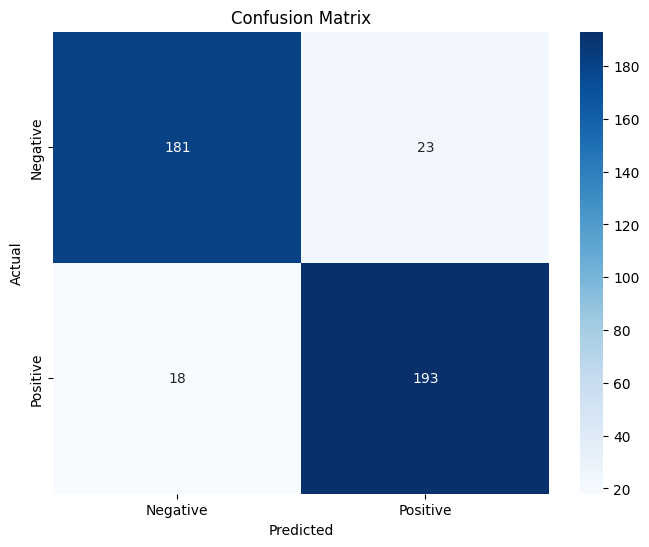

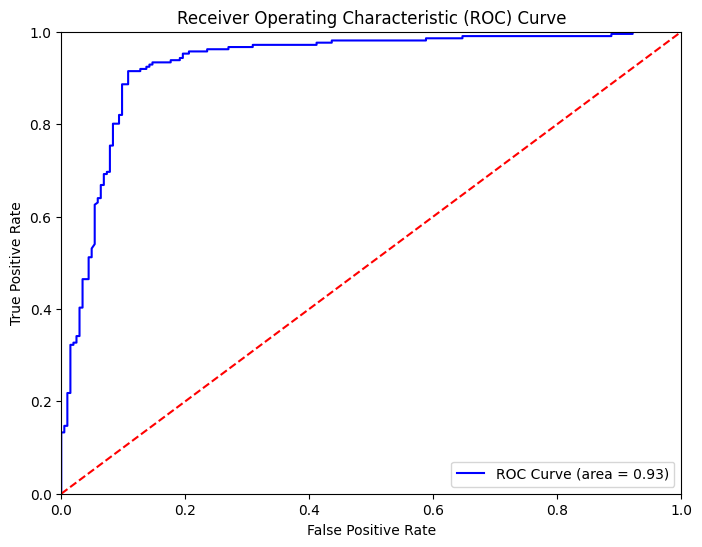

In [10]:
# Calculate metrics for validation data
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy_val)
print("Validation F1 Score:", f1_val)
print("Validation Precision:", precision_val)
print("Validation Recall:", recall_val)

# Plotting the confusion matrix for validation data
plot_confusion_matrix(conf_matrix_val)
plot_roc_curve(y_val, y_val_prob)

# Pregled rezulattov na podatkih za testiranje

Test Accuracy: 0.8795180722891566
Test F1 Score: 0.883177570093458
Test Precision: 0.8709677419354839
Test Recall: 0.8957345971563981


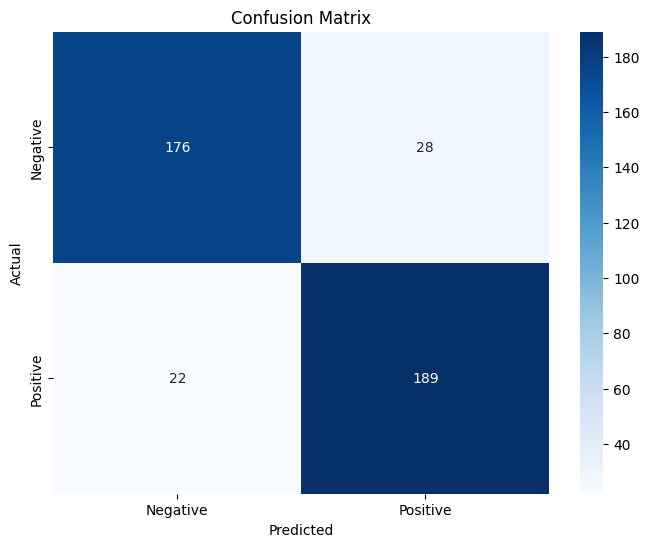

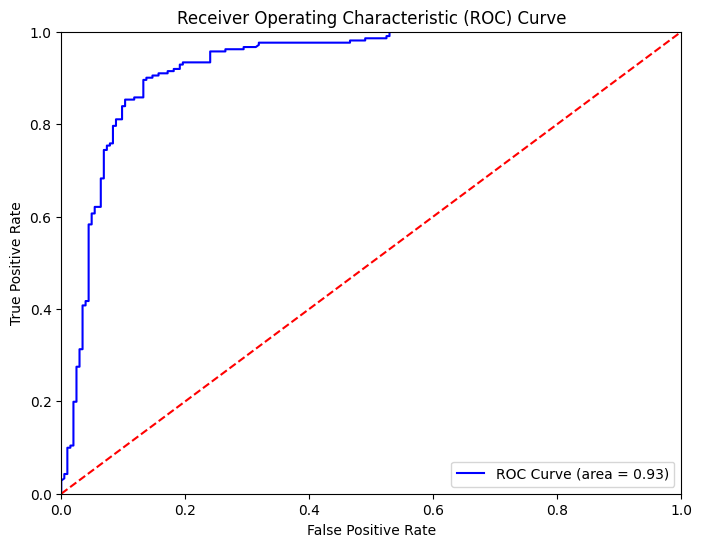

In [11]:
# Calculate metrics for test data
accuracy_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print("Test Accuracy:", accuracy_test)
print("Test F1 Score:", f1_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)

plot_confusion_matrix(conf_matrix_test)
plot_roc_curve(y_test, y_test_prob)
